In [11]:
text ='Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in "memory" about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each characters appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'

Epoch 1, Train Loss: 3.3148475383457385, Validation Loss: 3.1318199446326807, Train Acc: 0.11836231102872836, Val Acc: 0.1470923408081657, Epoch Time: 1.444864273071289s
Epoch 2, Train Loss: 3.099853183093824, Validation Loss: 3.078469947764748, Train Acc: 0.13972626920593412, Val Acc: 0.1487664470547124, Epoch Time: 1.070237159729004s
Epoch 3, Train Loss: 3.0628937608317326, Validation Loss: 3.08884859085083, Train Acc: 0.1420347739599253, Val Acc: 0.14776198213037692, Epoch Time: 1.0605273246765137s
Epoch 4, Train Loss: 3.062489704081887, Validation Loss: 3.0775958111411645, Train Acc: 0.14516564909564822, Val Acc: 0.14675751897065262, Epoch Time: 1.0673274993896484s
Epoch 5, Train Loss: 3.058003990273727, Validation Loss: 3.044251743115877, Train Acc: 0.14311560125727402, Val Acc: 0.1464226961528, Epoch Time: 1.0634043216705322s
Epoch 6, Train Loss: 3.0269830854315507, Validation Loss: 3.0246759841316626, Train Acc: 0.14809680494822955, Val Acc: 0.1484316265896747, Epoch Time: 1.106

KeyError: 'total_time'

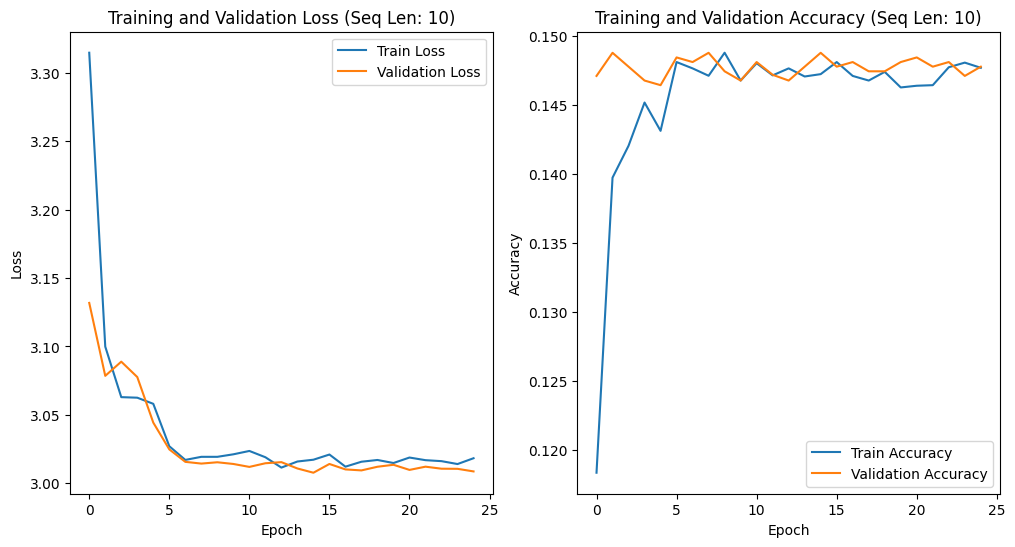

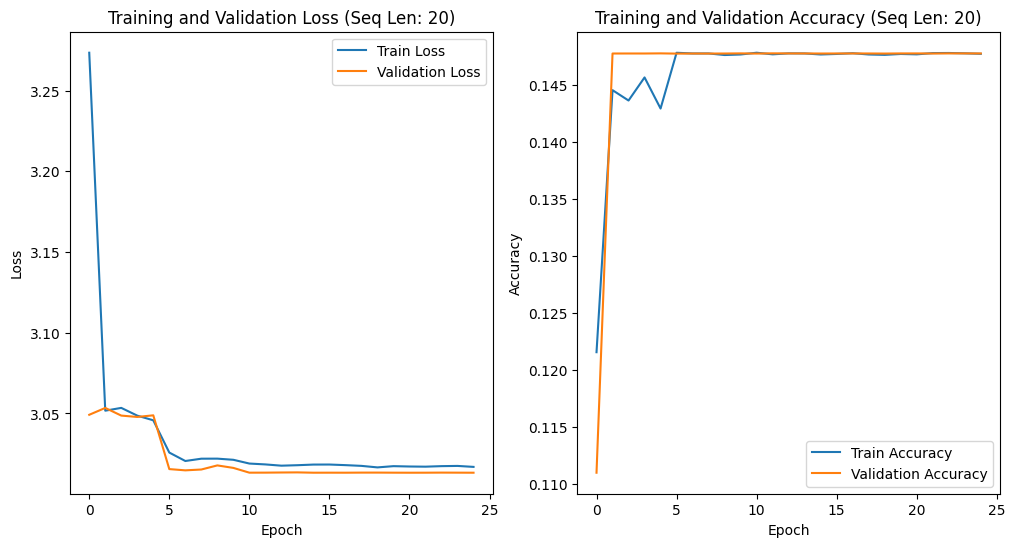

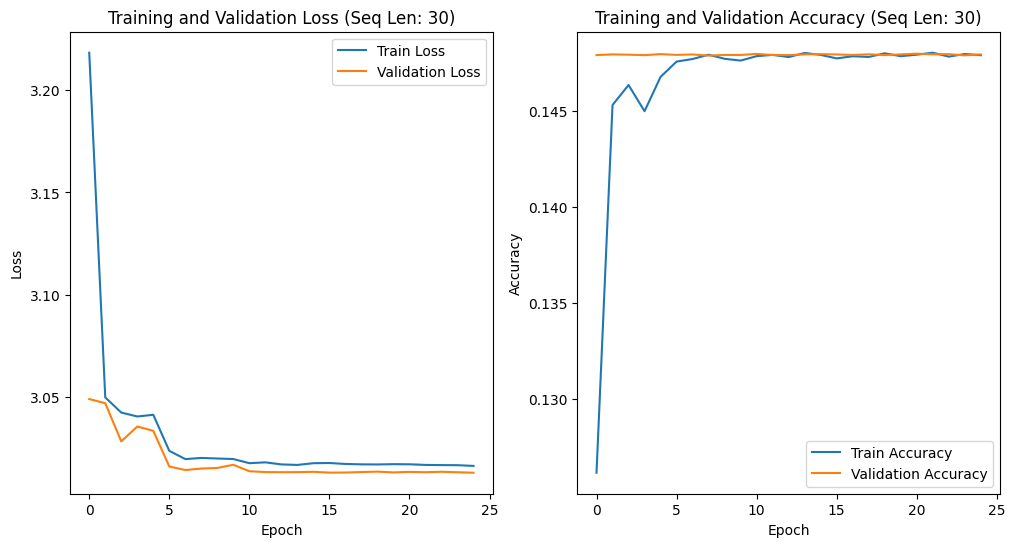

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time

class CharacterDataset(Dataset):
    def __init__(self, text, sequence_length):
        self.text = text
        self.sequence_length = sequence_length
        self.characters = sorted(list(set(text)))
        self.char_to_idx = {ch: idx for idx, ch in enumerate(self.characters)}
        self.idx_to_char = {idx: ch for idx, ch in enumerate(self.characters)}

    def __len__(self):
        return max(0, len(self.text) - self.sequence_length)

    def __getitem__(self, index):
        inputs = self.text[index:index + self.sequence_length]
        targets = self.text[index + 1:index + self.sequence_length + 1]
        input_indices = torch.tensor([self.char_to_idx[ch] for ch in inputs], dtype=torch.long)
        target_indices = torch.tensor([self.char_to_idx[ch] for ch in targets], dtype=torch.long)
        return input_indices, target_indices

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].to(x.device)

    def to(self, device):
        self.device = device
        super().to(device)
        return self

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_decoder_layers=4, dim_feedforward=2048, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=self.d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout_rate),
            num_layers=num_decoder_layers
        )
        self.fc_out = nn.Linear(self.d_model, vocab_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src):
        src = self.embedding(src) * np.sqrt(self.d_model)
        src = self.pos_encoder(src)
        src = self.dropout(src)
        output = self.transformer_decoder(src, src)
        return self.fc_out(output)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_acc = 0
    start_time = time.time()
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        acc = accuracy(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc.item()
    duration = time.time() - start_time
    return total_loss / len(data_loader), total_acc / len(data_loader), duration

def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            acc = accuracy(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            total_loss += loss.item()
            total_acc += acc.item()
    return total_loss / len(data_loader), total_acc / len(data_loader)

def main():
    sequence_lengths = [10, 20, 30]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}

    for seq_len in sequence_lengths:
        if seq_len >= len(text):
            continue
        
        dataset = CharacterDataset(text, sequence_length=seq_len)
        data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        model = TransformerModel(vocab_size=len(dataset.characters), num_decoder_layers=4, dropout_rate=0.1).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.005)  # Changed learning rate
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler
        
        train_losses, val_losses, train_accs, val_accs, epoch_times = [], [], [], [], []
        epochs = 25
        for epoch in range(epochs):
            train_loss, train_acc, epoch_time = train(model, data_loader, optimizer, criterion, device)
            val_loss, val_acc = validate(model, data_loader, criterion, device)
            
            scheduler.step()  # Decay Learning Rate
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            epoch_times.append(epoch_time)
            print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}, Epoch Time: {epoch_time}s')

        # Calculate overall accuracy
        overall_train_acc = sum(train_accs) / len(train_accs)
        overall_val_acc = sum(val_accs) / len(val_accs)
        
        results[seq_len] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'overall_train_acc': overall_train_acc,
            'overall_val_acc': overall_val_acc,
            'epoch_times': epoch_times
        }
        
        # Print overall results for the sequence length
        print(f"\nSequence Length: {seq_len}")
        print(f"Overall Training Accuracy: {overall_train_acc}")
        print(f"Overall Validation Accuracy: {overall_val_acc}")
        print(f"Total Training Time: {sum(epoch_times)}s\n")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Training and Validation Loss (Seq Len: {seq_len})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title(f'Training and Validation Accuracy (Seq Len: {seq_len})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    for seq_len, metrics in results.items():
        print(f"Sequence Length: {seq_len}")
        print(f"Overall Training Accuracy: {metrics['overall_train_acc']}")
        print(f"Overall Validation Accuracy: {metrics['overall_val_acc']}")
        print(f"Total Training Time: {metrics['total_time']}s\n")

if __name__ == "__main__":
    main()